# Sistema de recomendacion
### Dataset de Movie Lens

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use("seaborn-bright")
import seaborn as sns

In [14]:
url = r"C:\Users\gonza\OneDrive\Documentos\datascience-thebridge-master\ejercicios gonzalo\DATA\ml-100k\ml-100k\u.data"
df = pd.read_csv(url,sep="\t",names=["UserID","ItemID","Rating","Timestamp"],header=None)
df.head(3)

,UserID,ItemID,Rating,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116


### Analisis exploratorio

(array([ 6110.,     0., 11370.,     0.,     0., 27145.,     0., 34174.,
            0., 21201.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

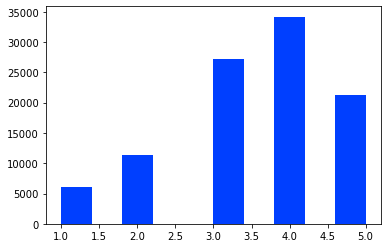

In [15]:
plt.hist(df.Rating)

In [18]:
# vemos como han valorado los usarios (igual que el histograma)
df.groupby("Rating")["UserID"].count()

Rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: UserID, dtype: int64

(array([1.146e+03, 2.490e+02, 1.390e+02, 6.700e+01, 3.800e+01, 2.400e+01,
        7.000e+00, 5.000e+00, 6.000e+00, 1.000e+00]),
 array([  1. ,  59.2, 117.4, 175.6, 233.8, 292. , 350.2, 408.4, 466.6,
        524.8, 583. ]),
 <a list of 10 Patch objects>)

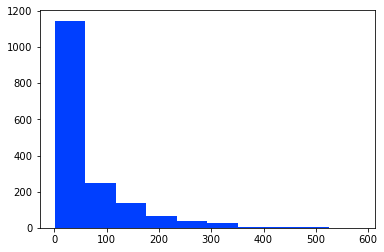

In [20]:
# aqui podemos ver cuanta gente ha visto cada pelicula (vemos que hay peliculas que han sido muy vistas)
plt.hist(df.groupby("ItemID")["ItemID"].count())

### Representacion Matricial
* para un sistema de recomendacion hace falta crear una matriz de recomendacion
* las filas seria usuario,  las columnas las pelicula, y los datos serian las valoraciones
* https://www.aprendemachinelearning.com/sistemas-de-recomendacion/

In [22]:
# numero usuarios
n_users = df.UserID.unique().shape[0]
n_users

943

In [23]:
# numero peliculas
n_items = df.ItemID.unique().shape[0]
n_items

1682

In [24]:
# nos hara una matrix de datos de recomendaciones (creamos una de 0)
ratings = np.zeros((n_users,n_items))

In [25]:
# ahora la completamos con las valoraciones
# lo que hacemos ahora no es muy eficiente (hacer un for por cada file) ¡ es una matrix sparse (con muchos ceros porque habra mucha gente que no haya visto ciertas peliculas), si fuera llena de datos seria una matriz dense
for row in df.itertuples():
    # row nos devulve una tupla con toda la fila / row[3] seria la valoracion
    ratings[row[1]-1,row[2]-1] = row[3]


In [26]:
# ahora la matrix esta completa (tendria muchos zeros) ¡¡ ojo los ceros son ausencia de datos no una valoracion
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [32]:
# vamos a ver el coeficiente de sparseidad (el porcentaje de la matriz que no esta vacia)
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0]*ratings.shape[1])
sparsity *= 100
print(f"Coeficiente de sparseidad {round(sparsity,2)}%")

Coeficiente de sparseidad 6.3%


### Crear conjunto entrenamiento

In [33]:
from sklearn.model_selection import train_test_split

# ojo solo dos variables train y test ¡¡
ratings_train, rating_test = train_test_split(ratings,test_size=0.3, random_state=0)

In [ ]:
# ahora buscaremos usuarios que se parezcan al que yo decida y hacer una suma ponderada de las valoraciones/peliculas de los usuarios que se le parezcan  para ofrecer una recomendacion

### Filtro colaborativo basado en usarios
* primero creamos una matriz de similaridad entre los usarios (distancia del coseno)
* despues predecir la valoracion desconocida de un item *i* para un usario activo *u* basandonos en  la suma de todas las valoraciones del resto de usarios de dicho item (aqui usaremos los k vecinos mas cercanos)
* recomendaremos los nuevos items a los usuarios segun lo establecido en los pasos anteriores

In [38]:
import sklearn
# creamos matriz de similaridad (cambiamos los ceros por los 1, ya que la distancia del coseno si es 0 es que estan juntos)
sim_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(ratings_train)
sim_matrix.shape

(660, 660)

In [40]:
# la matriz esta creada , tanto las filas como las columnas son los usarios, y los datos serian la distancia entre ellos
sim_matrix

array([[1.        , 0.20070493, 0.36410502, ..., 0.17711799, 0.22718243,
        0.18246643],
       [0.20070493, 1.        , 0.33730746, ..., 0.33869209, 0.33091285,
        0.03004467],
       [0.36410502, 0.33730746, 1.        , ..., 0.19492549, 0.28092839,
        0.        ],
       ...,
       [0.17711799, 0.33869209, 0.19492549, ..., 1.        , 0.28846546,
        0.04813431],
       [0.22718243, 0.33091285, 0.28092839, ..., 0.28846546, 1.        ,
        0.0898513 ],
       [0.18246643, 0.03004467, 0.        , ..., 0.04813431, 0.0898513 ,
        1.        ]])

In [41]:
users_predictions = sim_matrix.dot(ratings_train) / np.array([np.abs(sim_matrix).sum(axis=1)]).T

In [42]:
users_predictions

array([[2.12292732e+00, 5.95174406e-01, 3.60044524e-01, ...,
        0.00000000e+00, 0.00000000e+00, 6.69254658e-03],
       [2.41586924e+00, 6.17771929e-01, 4.68046514e-01, ...,
        0.00000000e+00, 0.00000000e+00, 6.57377386e-03],
       [2.51014729e+00, 7.19370696e-01, 4.32963196e-01, ...,
        0.00000000e+00, 0.00000000e+00, 1.01087178e-02],
       ...,
       [2.43112890e+00, 5.82284395e-01, 4.33577919e-01, ...,
        0.00000000e+00, 0.00000000e+00, 5.88282520e-03],
       [2.29250391e+00, 5.27397248e-01, 4.17983357e-01, ...,
        0.00000000e+00, 0.00000000e+00, 6.26641041e-03],
       [1.05920264e+00, 1.92102501e-01, 2.19387883e-01, ...,
        0.00000000e+00, 0.00000000e+00, 3.50755947e-04]])

In [43]:
from sklearn.metrics import mean_squared_error

In [44]:
def get_mse(preds, actuals):
    if preds.shape[0] != actuals.shape[0]:
        actuals = actuals.T
    preds = preds[actuals.nonzero()].flatten()
    actuals = actuals[actuals.nonzero()].flatten()
    return mean_squared_error(preds, actuals)

In [45]:
get_mse(users_predictions, ratings_train)

7.75301586344713

In [47]:
sim_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(rating_test)
users_predictions = sim_matrix.dot(rating_test) / np.array([np.abs(sim_matrix).sum(axis=1)]).T
get_mse(users_predictions, rating_test)

7.787355262682882

### Filtro colaborativo basado en los KNN
* normalmente no usamos todas las valoraciones de los usuarios, para recomendar hacemos una seleccion de usuarios con k neighbors

In [48]:
from sklearn.neighbors import NearestNeighbors

In [49]:
# establecemos el numero de k cercanos
k=10

In [50]:
neighbors = NearestNeighbors(k,"cosine")

In [51]:
neighbors.fit(ratings_train)

NearestNeighbors(n_neighbors=10, radius='cosine')

In [52]:
# ahora obtenemos los usuarios y sus distancias
top_k_distances, top_k_users = neighbors.kneighbors(ratings_train,return_distance=True)

In [53]:
# ahora podemos ver las distancias y los usarios "vecinos", por ejemplo para el usario 0
top_k_distances[0]

array([ 0.        , 25.92296279, 26.85144316, 26.88865932, 26.90724809,
       26.94438717, 27.33130074, 27.44084547, 27.47726333, 27.49545417])

In [55]:
top_k_users[0]

array([  0, 659, 540, 472, 359, 380, 353,  22, 334, 533], dtype=int64)

In [56]:
# para la prediccion hacemos la ponderacion de las valoraciones de los usuarios vecinos

users_predicts_k = np.zeros(ratings_train.shape)
for i in range(ratings_train.shape[0]):# para cada usuario del conjunto de entrenamiento
    users_predicts_k[i,:] = top_k_distances[i].T.dot(ratings_train[top_k_users][i]) / np.array([np.abs(top_k_distances[i].T).sum(axis=0)]).T

In [57]:
users_predicts_k.shape

(660, 1682)

In [58]:
users_predicts_k

array([[0.33114558, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [3.00150781, 0.        , 0.55447013, ..., 0.        , 0.        ,
        0.        ],
       [1.09359382, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [3.45117603, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.23344658, 0.        , 0.33773797, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [59]:
get_mse(users_predicts_k, ratings_train)

8.136551106231785

In [63]:
rating_test.shape

(283, 1682)

In [64]:
users_predicts_k = np.zeros(rating_test.shape)
users_predicts_k.shape

(283, 1682)

In [65]:

for i in range(rating_test.shape[0]):# para cada usuario del conjunto de test
    users_predicts_k[i,:] = top_k_distances[i].T.dot(rating_test[top_k_users][i]) / np.array([np.abs(top_k_distances[i].T).sum(axis=0)]).T
get_mse(users_predicts_k, rating_test)

IndexError: index 659 is out of bounds for axis 0 with size 283